In [1]:
import math
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.stats import wasserstein_distance
from torch import nn
import torch
import argparse
import numpy as np

## SCINet Model Definition

In [2]:
class Splitting(nn.Module):
    # downsamples the input sequence to 2 separate signals (odd and even)
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, ::2, :]

    def odd(self, x):
        return x[:, 1::2, :]

    def forward(self, x):
        '''Returns the odd and even part'''
        return (self.even(x), self.odd(x))

In [3]:
class Interactor(nn.Module):
    def __init__(self, in_planes, splitting=True,
                 kernel = 5, dropout=0.5, groups = 1, hidden_size = 1, INN = True):
        super(Interactor, self).__init__()
        self.modified = INN
        self.kernel_size = kernel
        self.dilation = 1
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.groups = groups
        if self.kernel_size % 2 == 0:
            pad_l = self.dilation * (self.kernel_size - 2) // 2 + 1 #by default: stride==1 
            pad_r = self.dilation * (self.kernel_size) // 2 + 1 #by default: stride==1 

        else:
            pad_l = self.dilation * (self.kernel_size - 1) // 2 + 1 # we fix the kernel size of the second layer as 3.
            pad_r = self.dilation * (self.kernel_size - 1) // 2 + 1
        self.splitting = splitting
        self.split = Splitting()

        modules_P = []
        modules_U = []
        modules_psi = []
        modules_phi = []
        prev_size = 1

        size_hidden = self.hidden_size
        modules_P += [
            nn.ReplicationPad1d((pad_l, pad_r)),

            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_U += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]

        modules_phi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_psi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        self.phi = nn.Sequential(*modules_phi)
        self.psi = nn.Sequential(*modules_psi)
        self.P = nn.Sequential(*modules_P)
        self.U = nn.Sequential(*modules_U)

    def forward(self, x):
        if self.splitting:
            (x_even, x_odd) = self.split(x)
        else:
            (x_even, x_odd) = x

        if self.modified:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd.mul(torch.exp(self.phi(x_even)))
            c = x_even.mul(torch.exp(self.psi(x_odd)))

            x_even_update = c + self.U(d)
            x_odd_update = d - self.P(c)

            return (x_even_update, x_odd_update)

        else:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd - self.P(x_even)
            c = x_even + self.U(d)

            return (c, d)

In [4]:
class InteractorLevel(nn.Module):
    def __init__(self, in_planes, kernel, dropout, groups , hidden_size, INN):
        super(InteractorLevel, self).__init__()
        self.level = Interactor(in_planes = in_planes, splitting=True,
                 kernel = kernel, dropout=dropout, groups = groups, hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.level(x)
        return (x_even_update, x_odd_update)

In [5]:
class LevelSCINet(nn.Module):
    def __init__(self,in_planes, kernel_size, dropout, groups, hidden_size, INN):
        super(LevelSCINet, self).__init__()
        self.interact = InteractorLevel(in_planes= in_planes, kernel = kernel_size, dropout = dropout, groups =groups , hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.interact(x)
        return x_even_update.permute(0, 2, 1), x_odd_update.permute(0, 2, 1) #even: B, T, D odd: B, T, D

In [6]:
class SCINet_Tree(nn.Module):
    def __init__(self, in_planes, current_level, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.current_level = current_level


        self.workingblock = LevelSCINet(
            in_planes = in_planes,
            kernel_size = kernel_size,
            dropout = dropout,
            groups= groups,
            hidden_size = hidden_size,
            INN = INN)


        if current_level!=0:
            self.SCINet_Tree_odd=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
            self.SCINet_Tree_even=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
    
    def zip_up_the_pants(self, even, odd):
        even = even.permute(1, 0, 2)
        odd = odd.permute(1, 0, 2) #L, B, D
        even_len = even.shape[0]
        odd_len = odd.shape[0]
        mlen = min((odd_len, even_len))
        _ = []
        for i in range(mlen):
            _.append(even[i].unsqueeze(0))
            _.append(odd[i].unsqueeze(0))
        if odd_len < even_len: 
            _.append(even[-1].unsqueeze(0))
        return torch.cat(_,0).permute(1,0,2) #B, L, D
        
    def forward(self, x):
        x_even_update, x_odd_update= self.workingblock(x)
        # We recursively reordered these sub-series. You can run the ./utils/recursive_demo.py to emulate this procedure. 
        if self.current_level ==0:
            return self.zip_up_the_pants(x_even_update, x_odd_update)
        else:
            return self.zip_up_the_pants(self.SCINet_Tree_even(x_even_update), self.SCINet_Tree_odd(x_odd_update))

In [7]:
class EncoderTree(nn.Module):
    def __init__(self, in_planes,  num_levels, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.levels=num_levels
        self.SCINet_Tree = SCINet_Tree(
            in_planes = in_planes,
            current_level = num_levels-1,
            kernel_size = kernel_size,
            dropout =dropout ,
            groups = groups,
            hidden_size = hidden_size,
            INN = INN)
        
    def forward(self, x):

        x= self.SCINet_Tree(x)

        return x

In [8]:
class SCINet(nn.Module):
    def __init__(self, output_len, input_len, input_dim = 9, hid_size = 1, num_stacks = 1,
                num_levels = 3, num_decoder_layer = 1, concat_len = 0, groups = 1, kernel = 5, dropout = 0.5,
                 single_step_output_One = 0, input_len_seg = 0, positionalE = False, modified = True, RIN=False):
        super(SCINet, self).__init__()

        self.input_dim = input_dim
        self.input_len = input_len
        self.output_len = output_len
        self.hidden_size = hid_size
        self.num_levels = num_levels
        self.groups = groups
        self.modified = modified
        self.kernel_size = kernel
        self.dropout = dropout
        self.single_step_output_One = single_step_output_One
        self.concat_len = concat_len
        self.pe = positionalE
        self.RIN=RIN
        self.num_decoder_layer = num_decoder_layer

        self.blocks1 = EncoderTree(
            in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN =  modified)

        if num_stacks == 2: # we only implement two stacks at most.
            self.blocks2 = EncoderTree(
                in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN =  modified)

        self.stacks = num_stacks

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        self.projection1 = nn.Conv1d(self.input_len, self.output_len, kernel_size=1, stride=1, bias=False)
        self.div_projection = nn.ModuleList()
        self.overlap_len = self.input_len//4
        self.div_len = self.input_len//6

        if self.num_decoder_layer > 1:
            self.projection1 = nn.Linear(self.input_len, self.output_len)
            for layer_idx in range(self.num_decoder_layer-1):
                div_projection = nn.ModuleList()
                for i in range(6):
                    lens = min(i*self.div_len+self.overlap_len,self.input_len) - i*self.div_len
                    div_projection.append(nn.Linear(lens, self.div_len))
                self.div_projection.append(div_projection)

        if self.single_step_output_One: # only output the N_th timestep.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
        else: # output the N timesteps.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)

        # For positional encoding
        self.pe_hidden_size = input_dim
        if self.pe_hidden_size % 2 == 1:
            self.pe_hidden_size += 1
    
        num_timescales = self.pe_hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0

        log_timescale_increment = (
                math.log(float(max_timescale) / float(min_timescale)) /
                max(num_timescales - 1, 1))
        temp = torch.arange(num_timescales, dtype=torch.float32)
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)

        ### RIN Parameters ###
        if self.RIN:
            self.affine_weight = nn.Parameter(torch.ones(1, 1, input_dim))
            self.affine_bias = nn.Parameter(torch.zeros(1, 1, input_dim))
    
    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32, device=x.device)  # tensor([0., 1., 2., 3., 4.], device='cuda:0')
        temp1 = position.unsqueeze(1)  # 5 1
        temp2 = self.inv_timescales.unsqueeze(0)  # 1 256
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)  # 5 256
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)  #[T, C]
        signal = F.pad(signal, (0, 0, 0, self.pe_hidden_size % 2))
        signal = signal.view(1, max_length, self.pe_hidden_size)
    
        return signal

    def forward(self, x):
        assert self.input_len % (np.power(2, self.num_levels)) == 0 # evenly divided the input length into two parts. (e.g., 32 -> 16 -> 8 -> 4 for 3 levels)
        if self.pe:
            pe = self.get_position_encoding(x)
            if pe.shape[2] > x.shape[2]:
                x += pe[:, :, :-1]
            else:
                x += self.get_position_encoding(x)

        ### activated when RIN flag is set ###
        if self.RIN:
            print('/// RIN ACTIVATED ///\r',end='')
            means = x.mean(1, keepdim=True).detach()
            #mean
            x = x - means
            #var
            stdev = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x /= stdev
            # affine
            # print(x.shape,self.affine_weight.shape,self.affine_bias.shape)
            x = x * self.affine_weight + self.affine_bias

        # the first stack
        res1 = x
        x = self.blocks1(x)
        x += res1
        if self.num_decoder_layer == 1:
            x = self.projection1(x)
        else:
            x = x.permute(0,2,1)
            for div_projection in self.div_projection:
                output = torch.zeros(x.shape,dtype=x.dtype).to(device)
                for i, div_layer in enumerate(div_projection):
                    div_x = x[:,:,i*self.div_len:min(i*self.div_len+self.overlap_len,self.input_len)]
                    output[:,:,i*self.div_len:(i+1)*self.div_len] = div_layer(div_x)
                x = output
            x = self.projection1(x)
            x = x.permute(0,2,1)

        if self.stacks == 1:
            ### reverse RIN ###
            if self.RIN:
                x = x - self.affine_bias
                x = x / (self.affine_weight + 1e-10)
                x = x * stdev
                x = x + means

            return x

        elif self.stacks == 2:
            MidOutPut = x
            if self.concat_len:
                x = torch.cat((res1[:, -self.concat_len:,:], x), dim=1)
            else:
                x = torch.cat((res1, x), dim=1)

            # the second stack
            res2 = x
            x = self.blocks2(x)
            x += res2
            x = self.projection2(x)
            
            ### Reverse RIN ###
            if self.RIN:
                MidOutPut = MidOutPut - self.affine_bias
                MidOutPut = MidOutPut / (self.affine_weight + 1e-10)
                MidOutPut = MidOutPut * stdev
                MidOutPut = MidOutPut + means

            if self.RIN:
                x = x - self.affine_bias
                x = x / (self.affine_weight + 1e-10)
                x = x * stdev
                x = x + means

            return x, MidOutPut

## DLinear Model Definition

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(DLinear, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

## Data Loading and Preprocessing

In [10]:
import os
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data_name = "ETTh1.csv"
ett = os.path.join("drive/MyDrive", data_name)

In [12]:
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean

### Pandas Time Series Processing

In [13]:
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from typing import List

class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"

class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5

class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5

class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5

class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5

class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5

class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5

class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5

class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)

def time_features(dates, timeenc=1, freq='h'):
    if timeenc==0:
        dates['month'] = dates.date.apply(lambda row:row.month,1)
        dates['day'] = dates.date.apply(lambda row:row.day,1)
        dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
        dates['hour'] = dates.date.apply(lambda row:row.hour,1)
        dates['minute'] = dates.date.apply(lambda row:row.minute,1)
        dates['minute'] = dates.minute.map(lambda x:x//15)
        freq_map = {
            'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
            'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
            't':['month','day','weekday','hour','minute'],
        }
        return dates[freq_map[freq.lower()]].values
    if timeenc==1:
        dates = pd.to_datetime(dates.date.values)
        return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)]).transpose(1,0)

### Custom Dataloader for ETTh

In [14]:
class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=None, 
                 features='S', data_path='ETTh1.csv', 
                 target='OT', scale=True, inverse=False, timeenc=0, freq='h', cols=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train':0, 'val':1, 'test':2}
        self.set_type = type_map[flag]
        
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12*30*24 - self.seq_len, 12*30*24+4*30*24 - self.seq_len]
        border2s = [12*30*24, 12*30*24+4*30*24, 12*30*24+8*30*24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        if self.features=='M' or self.features=='MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
            # data = self.scaler.fit_transform(df_data.values)
        else:
            data = df_data.values
            
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)
        
        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len 
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]  # 0 - 24
        seq_y = self.data_y[r_begin:r_end] # 0 - 48
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

### Utilities

In [15]:
def save_model(epoch, lr, model, model_dir, model_name='pems08', horizon=12):
    if model_dir is None:
        return
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    file_name = os.path.join(model_dir, model_name+str(horizon)+'.bin')
    torch.save(
        {
        'epoch': epoch,
        'lr': lr,
        'model': model.state_dict(),
        }, file_name)
    print('save model in ',file_name)


def load_model(model, model_dir, model_name='pems08', horizon=12):
    if not model_dir:
        return
    file_name = os.path.join(model_dir, model_name+str(horizon)+'.bin') 

    if not os.path.exists(file_name):
        return
    with open(file_name, 'rb') as f:
        checkpoint = torch.load(f, map_location=lambda storage, loc: storage)
        print('This model was trained for {} epochs'.format(checkpoint['epoch']))
        model.load_state_dict(checkpoint['model'])
        epoch = checkpoint['epoch']
        lr = checkpoint['lr']
        print('loaded the model...', file_name, 'now lr:', lr, 'now epoch:', epoch)
    return model, lr, epoch

def adjust_learning_rate(optimizer, epoch, lr):
    lr_adjust = {epoch: lr * (0.95 ** (epoch // 1))} # 0.95 lr decay

    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))
    else:
        for param_group in optimizer.param_groups:
            lr = param_group['lr']
    return lr
  
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path+'/'+'checkpoint.pth')
        self.val_loss_min = val_loss

### Metrics Definition

In [16]:
def RSE(pred, true):
    return np.sqrt(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))

def CORR(pred, true):
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0) 
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean()

def Corr(pred, true):
    sig_p = np.std(pred, axis=0)
    sig_g = np.std(true, axis=0)
    m_p = pred.mean(0)
    m_g = true.mean(0)
    ind = (sig_g != 0)
    corr = ((pred - m_p) * (true - m_g)).mean(0) / (sig_p * sig_g)
    corr = (corr[ind]).mean()
    return corr

def MAE(pred, true):
    return np.mean(np.abs(pred-true))

def MSE(pred, true):
    return np.mean((pred-true)**2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    #corr1 = CORR(pred, true)
    corr = Corr(pred, true)
    return mae,mse,rmse,mape,mspe,corr

## Experiment

### Model Definition

In [17]:
import time
from torch.utils.tensorboard import SummaryWriter
from torch import optim

In [18]:
train_data = Dataset_ETT_hour(root_path = "drive/MyDrive", flag="train")
test_data = Dataset_ETT_hour(root_path = "drive/MyDrive", flag="test")
valid_data = Dataset_ETT_hour(root_path = "drive/MyDrive", flag="val")

In [19]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [20]:
# needed for SCINet to process one batch
# because of the parameter "stacks" which changes the loss structure
def _process_one_batch_SCINet(model, stacks, dataset_object, batch_x, batch_y):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float()

        if stacks == 1:
            outputs = model(batch_x)
        elif stacks == 2:
            outputs, mid = model(batch_x)
        else:
            print('Error!')

        #if self.args.inverse:
        outputs_scaled = dataset_object.inverse_transform(outputs)
        if stacks == 2:
            mid_scaled = dataset_object.inverse_transform(mid)
        f_dim = 0
        batch_y = batch_y[:,-96:,f_dim:].cuda()
        batch_y_scaled = dataset_object.inverse_transform(batch_y)

        if stacks == 1:
            return outputs, outputs_scaled, 0,0, batch_y, batch_y_scaled
        elif stacks == 2:
            return outputs, outputs_scaled, mid, mid_scaled, batch_y, batch_y_scaled

In [21]:
# called at the end of each epoch for validation loss and test loss
def valid(model, use_model, config, valid_data, valid_loader, criterion):
  model.eval()
  total_loss = []
  time_now = time.time()
  count = 0
  for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(valid_loader):
    if use_model == "SCI":
      stacks = config.stacks
      pred, pred_scale, mid, mid_scale, true, true_scale = _process_one_batch_SCINet(
          model, stacks, valid_data, batch_x, batch_y)

      if stacks == 1:
          loss = criterion(pred.detach().cpu(), true.detach().cpu())

      elif stacks == 2:
          loss = criterion(pred.detach().cpu(), true.detach().cpu()) + criterion(mid.detach().cpu(), true.detach().cpu())
      else:
          print('Error!')
    else:
      batch_x = batch_x.float().to(device)
      true = batch_y[:,-96:,0:].float().to(device)
      pred = model(batch_x)
      loss = criterion(pred.detach().cpu(), true.detach().cpu())

    total_loss.append(loss)
    count += 1
  total_time = time.time() - time_now
  total_loss = np.average(total_loss)
  print('\tspeed: {:.4f}s/iter; elapsed time: {:.4f}s'.format(total_time/count, total_time))
  return total_loss

In [22]:
class ConfigSCINet:
  def __init__(self, lr, dropout, batch_size, hidden_size, kernel, window_size,
               stacks, levels, decoder_layers):
    self.lr = lr
    self.dropout = dropout
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    self.kernel = kernel
    self.window_size = window_size
    self.stacks = stacks
    self.levels = levels
    self.decoder_layers = decoder_layers


test_config_SCI = ConfigSCINet(0.0001, 0.5, 128, 1, 5, 12, 1, 3, 1)

class ConfigDLinear:
  def __init__(self, lr, batch_size, seq_len, pred_len, individual, enc_in):
    self.lr = lr
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.individual = individual
    self.enc_in = enc_in
    self.features = 'S'

test_config_DLinear = ConfigDLinear(0.0001, 128, 384, 96, True, 1)

In [23]:
def train(config = None, use_model = 'SCI', profile_test = False, use_amp = False, resume = False, train_epochs = 100):
      path = os.path.join("exp/", use_model)
      print(path)
      if not os.path.exists(path):
          os.makedirs(path)
      writer = SummaryWriter('event/run_ETTh/{}'.format("SCINet"))

      train_loader = DataLoader(
                  train_data,
                  batch_size=config.batch_size,
                  shuffle=True,
                  num_workers=2,
                  drop_last=False)

      test_loader = DataLoader(
                  test_data,
                  batch_size=config.batch_size,
                  shuffle=False,
                  num_workers=2,
                  drop_last=True)

      valid_loader = DataLoader(
                  valid_data,
                  batch_size=config.batch_size,
                  shuffle=True,
                  num_workers=2,
                  drop_last=False)

      time_now = time.time()
      
      train_steps = len(train_loader)
      early_stopping = EarlyStopping(patience=7, verbose=True)
      
      if use_model == "SCI":
        model = SCINet(
                  output_len=96,
                  input_len=384,
                  input_dim= 1,
                  hid_size = config.hidden_size,
                  num_stacks=config.stacks,
                  num_levels=config.levels,
                  num_decoder_layer=config.decoder_layers,
                  concat_len = 0,
                  groups = 1,
                  kernel = config.kernel,
                  dropout = config.dropout,
                  single_step_output_One = 0,
                  positionalE = False,
                  modified = True,
                  RIN=False)
      
      else:
        model = DLinear(config)
      
      model.to(device)
      
      model_optim = optim.Adam(model.parameters(), lr=config.lr)
      criterion =  nn.MSELoss()

      # if use_amp: # automatic mixed-precision training
      #     scaler = torch.cuda.amp.GradScaler()

      # if resume:
      #     model, lr, epoch_start = load_model(model, path, model_name="SCINet", horizon=96)
      lr = config.lr
      epoch_start = 0
      
      # testing 10 iterations for profiling
      if profile_test:
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
          if i >= 10:
            return

          model_optim.zero_grad()
          if use_model == "SCI":
            pred, pred_scale, mid, mid_scale, true, true_scale = _process_one_batch_SCINet(
                  model, config.stacks, train_data, batch_x, batch_y)

            if config.stacks == 1:
                loss = criterion(pred, true)
            elif config.stacks == 2:
                loss = criterion(pred, true) + criterion(mid, true)
          else:
            batch_x = batch_x.float().to(device)
            true = batch_y[:,-96:,0:].float().to(device)
            print(true.shape)
            pred = model(batch_x)
            loss = criterion(pred, true)
          
          loss.backward()
          model_optim.step()
        

      for epoch in range(epoch_start, train_epochs):
          iter_count = 0
          train_loss = []
          
          model.train()
          epoch_time = time.time()
          for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
              iter_count += 1
              
              model_optim.zero_grad()
              if use_model == "SCI":
                pred, pred_scale, mid, mid_scale, true, true_scale = _process_one_batch_SCINet(
                      model, config.stacks, train_data, batch_x, batch_y)

                if config.stacks == 1:
                    loss = criterion(pred, true)
                elif config.stacks == 2:
                    loss = criterion(pred, true) + criterion(mid, true)
              
              else:
                batch_x = batch_x.float().to(device)
                true = batch_y[:,-96:,0:].float().to(device)
                pred = model(batch_x)
                loss = criterion(pred, true)
  
              train_loss.append(loss.item())
              
              if (i+1) % 100==0:
                  print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                  speed = (time.time()-time_now)/iter_count
                  print('\tspeed: {:.4f}s/iter; elapsed time: {:.4f}s'.format(speed, time.time()-time_now))
                  iter_count = 0
                  time_now = time.time()
              
              loss.backward()
              model_optim.step()

          print("Epoch: {} cost time: {}".format(epoch+1, time.time()-epoch_time))
          train_loss = np.average(train_loss)
          print('--------start to validate-----------')
          valid_loss = valid(model, use_model, config, valid_data, valid_loader, criterion)
          print('--------start to test-----------')
          test_loss = valid(model, use_model, config, test_data, test_loader, criterion)

          print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} valid Loss: {3:.7f} Test Loss: {4:.7f}".format(
              epoch + 1, train_steps, train_loss, valid_loss, test_loss))

          writer.add_scalar('train_loss', train_loss, global_step=epoch)
          writer.add_scalar('valid_loss', valid_loss, global_step=epoch)
          writer.add_scalar('test_loss', test_loss, global_step=epoch)

          early_stopping(valid_loss, model, path)
          if early_stopping.early_stop:
              print("Early stopping")
              break

          lr = adjust_learning_rate(model_optim, epoch+1, lr)
          
      save_model(epoch, lr, model, path, model_name=use_model, horizon=96)
      best_model_path = path+'/'+'checkpoint.pth'
      model.load_state_dict(torch.load(best_model_path))
      return model

In [24]:
train(test_config_DLinear, use_model="DLinear")

exp/DLinear
Epoch: 1 cost time: 3.4711694717407227
--------start to validate-----------
	speed: 0.0128s/iter; elapsed time: 0.2811s
--------start to test-----------
	speed: 0.0135s/iter; elapsed time: 0.2831s
Epoch: 1, Steps: 64 | Train Loss: 0.4693839 valid Loss: 0.1430786 Test Loss: 0.1141613
Validation loss decreased (inf --> 0.143079).  Saving model ...
Updating learning rate to 9.5e-05
Epoch: 2 cost time: 0.593759298324585
--------start to validate-----------
	speed: 0.0122s/iter; elapsed time: 0.2679s
--------start to test-----------
	speed: 0.0126s/iter; elapsed time: 0.2655s
Epoch: 2, Steps: 64 | Train Loss: 0.2068968 valid Loss: 0.1313067 Test Loss: 0.0917227
Validation loss decreased (0.143079 --> 0.131307).  Saving model ...
Updating learning rate to 8.57375e-05
Epoch: 3 cost time: 0.5803518295288086
--------start to validate-----------
	speed: 0.0126s/iter; elapsed time: 0.2762s
--------start to test-----------
	speed: 0.0136s/iter; elapsed time: 0.2863s
Epoch: 3, Steps: 64

DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): ModuleList(
    (0): Linear(in_features=384, out_features=96, bias=True)
  )
  (Linear_Trend): ModuleList(
    (0): Linear(in_features=384, out_features=96, bias=True)
  )
)

In [25]:
train(test_config_SCI)

exp/SCI
Epoch: 1 cost time: 10.103235960006714
--------start to validate-----------
	speed: 0.0326s/iter; elapsed time: 0.7180s
--------start to test-----------
	speed: 0.0325s/iter; elapsed time: 0.6832s
Epoch: 1, Steps: 64 | Train Loss: 1.9597573 valid Loss: 0.3298185 Test Loss: 0.2790440
Validation loss decreased (inf --> 0.329818).  Saving model ...
Updating learning rate to 9.5e-05
Epoch: 2 cost time: 5.05372428894043
--------start to validate-----------
	speed: 0.0440s/iter; elapsed time: 0.9673s
--------start to test-----------
	speed: 0.0481s/iter; elapsed time: 1.0101s
Epoch: 2, Steps: 64 | Train Loss: 0.9572571 valid Loss: 0.2512842 Test Loss: 0.1866940
Validation loss decreased (0.329818 --> 0.251284).  Saving model ...
Updating learning rate to 8.57375e-05
Epoch: 3 cost time: 5.577123641967773
--------start to validate-----------
	speed: 0.0320s/iter; elapsed time: 0.7038s
--------start to test-----------
	speed: 0.0318s/iter; elapsed time: 0.6676s
Epoch: 3, Steps: 64 | Tra

SCINet(
  (blocks1): EncoderTree(
    (SCINet_Tree): SCINet_Tree(
      (workingblock): LevelSCINet(
        (interact): InteractorLevel(
          (level): Interactor(
            (split): Splitting()
            (phi): Sequential(
              (0): ReplicationPad1d((3, 3))
              (1): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
              (2): LeakyReLU(negative_slope=0.01, inplace=True)
              (3): Dropout(p=0.5, inplace=False)
              (4): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
              (5): Tanh()
            )
            (psi): Sequential(
              (0): ReplicationPad1d((3, 3))
              (1): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
              (2): LeakyReLU(negative_slope=0.01, inplace=True)
              (3): Dropout(p=0.5, inplace=False)
              (4): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
              (5): Tanh()
            )
            (P): Sequential(
              (0): ReplicationPad1d((3, 3))
              (1)

### Hyperparameter Sweep

In [ ]:
!pip install wandb -Uq # install wandb
import wandb
wandb.login()

In [ ]:
config = {
    'method': 'random'
}

config_metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

config['metric'] = config_metric

parameters_dict = {
    'lr': {
        'values': [0.0001, 0.00025, 0.0005, 0.001]
        },
    'dropout': {
        'values': [0, 0.3, 0.5, 0.7]
    },
    'hidden_size': { # hidden size in convulution 
        'values': [1, 2, 3]
    },
    'kernel': { # kernel size for convulution
        'values': [3, 5, 7]
    },
    'window_size': { # lookback window
        'values': [8, 12, 14]
    },
    'stacks': { # number of SCINet Blocks to use
        'values': [1, 2]
    },
    'decoder_layers': {
        'values': [1, 2]
    },
    'levels': { # level of binary trees inside a SCINet Block
        'values': [2, 3, 4, 5]
    }
}
    
config['parameters'] = parameters_dict

In [ ]:
def train_sweep(config = None, use_amp = False, resume = False, train_epochs = 100):
  with wandb.init(config=config):
      config = wandb.config
      setting = 'lr{}_dp{}_hid{}_kern_{}_win_{}_s{}_lv{}_de{}'.format(
          config.lr, config.dropout, config.hidden_size, config.kernel,
          config.window_size, config.stacks, config.levels, config.decoder_layers)
      path = os.path.join("exp/", setting)
      print(path)
      if not os.path.exists(path):
          os.makedirs(path)
      writer = SummaryWriter('event/run_ETTh/{}'.format("SCINet"))

      time_now = time.time()
      
      train_steps = len(train_loader)
      early_stopping = EarlyStopping(patience=7, verbose=True)
      
      model = SCINet(
                output_len=96,
                input_len=384,
                input_dim= 1,
                hid_size = config.hidden_size,
                num_stacks=config.stacks,
                num_levels=config.levels,
                num_decoder_layer=config.decoder_layers,
                concat_len = 0,
                groups = 1,
                kernel = config.kernel,
                dropout = config.dropout,
                single_step_output_One = 0,
                positionalE = False,
                modified = True,
                RIN=False)
      
      model.double().to(device)
      
      model_optim = optim.Adam(model.parameters(), lr=config.lr)
      criterion =  nn.MSELoss()

      if use_amp: # automatic mixed-precision training
          scaler = torch.cuda.amp.GradScaler()

      if resume:
          model, lr, epoch_start = load_model(model, path, model_name="SCINet", horizon=96)
      else:
          lr = config.lr
          epoch_start = 0

      for epoch in range(epoch_start, train_epochs):
          iter_count = 0
          train_loss = []
          
          model.train()
          epoch_time = time.time()
          for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
              iter_count += 1
              
              model_optim.zero_grad()
              pred, pred_scale, mid, mid_scale, true, true_scale = _process_one_batch_SCINet(
                    model, config.stacks, train_data, batch_x, batch_y)

              if config.stacks == 1:
                  loss = criterion(pred, true)
              elif config.stacks == 2:
                  loss = criterion(pred, true) + criterion(mid, true)
              else:
                  print('Error!')

              train_loss.append(loss.item())
              
              if (i+1) % 100==0:
                  print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                  speed = (time.time()-time_now)/iter_count
                  left_time = speed*((train_epochs - epoch)*train_steps - i)
                  print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                  iter_count = 0
                  time_now = time.time()
              
              if use_amp:
                  print('use amp')    
                  scaler.scale(loss).backward()
                  scaler.step(model_optim)
                  scaler.update()
              else:
                  loss.backward()
                  model_optim.step()

          print("Epoch: {} cost time: {}".format(epoch+1, time.time()-epoch_time))
          train_loss = np.average(train_loss)
          wandb.log({"loss": train_loss, "epoch": epoch+1})
          print('--------start to validate-----------')
          valid_loss = valid(model, config.stacks, valid_data, valid_loader, criterion)
          print('--------start to test-----------')
          test_loss = valid(model, config.stacks, test_data, test_loader, criterion)

          print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} valid Loss: {3:.7f} Test Loss: {4:.7f}".format(
              epoch + 1, train_steps, train_loss, valid_loss, test_loss))

          writer.add_scalar('train_loss', train_loss, global_step=epoch)
          writer.add_scalar('valid_loss', valid_loss, global_step=epoch)
          writer.add_scalar('test_loss', test_loss, global_step=epoch)

          early_stopping(valid_loss, model, path)
          if early_stopping.early_stop:
              print("Early stopping")
              break

          lr = adjust_learning_rate(model_optim, epoch+1, lr)
          
      save_model(epoch, lr, model, path, model_name="SCINet", horizon=96)
      best_model_path = path+'/'+'checkpoint.pth'
      model.load_state_dict(torch.load(best_model_path))
      return model

In [ ]:
sweep_id = wandb.sweep(config, project="SCINet")
wandb.agent(sweep_id, train_sweep, count=100)

### Profiling

In [ ]:
!pip install torch-tb-profiler

In [ ]:
import torch.profiler
from torch.profiler import profile, record_function, ProfilerActivity

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_SCI = SCINet(
                output_len=96,
                input_len=384,
                input_dim= 1,
                hid_size = test_config_SCI.hidden_size,
                num_stacks=test_config_SCI.stacks,
                num_levels=test_config_SCI.levels,
                num_decoder_layer=test_config_SCI.decoder_layers,
                concat_len = 0,
                groups = 1,
                kernel = test_config_SCI.kernel,
                dropout = test_config_SCI.dropout,
                single_step_output_One = 0,
                positionalE = False,
                modified = True,
                RIN=False)

model_SCI.to(device)
      
model_optim = optim.Adam(model_SCI.parameters(), lr=test_config_SCI.lr)
criterion =  nn.MSELoss()

train_loader = DataLoader(
            train_data,
            batch_size=test_config_SCI.batch_size,
            shuffle=True,
            num_workers=2,
            drop_last=False)

test_loader = DataLoader(
            test_data,
            batch_size=test_config_SCI.batch_size,
            shuffle=False,
            num_workers=2,
            drop_last=True)


### training profiling
model_SCI.train()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
             record_shapes=True, profile_memory=True, 
             on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/SCINet_train')) as prof:
              for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
                if i > 20:
                  break
                model_optim.zero_grad()
                pred, pred_scale, mid, mid_scale, true, true_scale = _process_one_batch_SCINet(
                    model_SCI, test_config_SCI.stacks, train_data, batch_x, batch_y)

                if test_config_SCI.stacks == 1:
                    loss = criterion(pred, true)
                elif test_config_SCI.stacks == 2:
                    loss = criterion(pred, true) + criterion(mid, true)
                loss.backward()
                model_optim.step()
                prof.step()


### inference profiling
model_SCI.eval()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
             record_shapes=True, profile_memory=True, 
             on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/SCINet_inference')) as prof:
              for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
                if i > 20:
                  break
                model_optim.zero_grad()
                pred, pred_scale, mid, mid_scale, true, true_scale = _process_one_batch_SCINet(
                    model_SCI, test_config_SCI.stacks, train_data, batch_x, batch_y)
                prof.step()

In [ ]:
torch.cuda.empty_cache()
DL_model = DLinear(test_config_DLinear)
DL_model.to(device)
      
model_optim = optim.Adam(DL_model.parameters(), lr=test_config_DLinear.lr)
criterion =  nn.MSELoss()

train_loader = DataLoader(
            train_data,
            batch_size=test_config_DLinear.batch_size,
            shuffle=True,
            num_workers=2,
            drop_last=False)

test_loader = DataLoader(
            test_data,
            batch_size=test_config_DLinear.batch_size,
            shuffle=False,
            num_workers=2,
            drop_last=True)


### training profiling
DL_model.train()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
             record_shapes=True, profile_memory=True, 
             on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/DLinear_train')) as prof:
              for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
                if i > 20:
                  break
                model_optim.zero_grad()
                batch_x = batch_x.float().to(device)
                true = batch_y[:,-96:,0:].float().to(device)
                pred = DL_model(batch_x)
                loss = criterion(pred, true)
                loss.backward()
                model_optim.step()
                prof.step()


### inference profiling
DL_model.eval()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
             record_shapes=True, profile_memory=True, 
             on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/DLinear_inference')) as prof:
              for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
                if i > 20:
                  break
                model_optim.zero_grad()
                batch_x = batch_x.float().to(device)
                true = batch_y[:,-96:,0:].float().to(device)
                pred = DL_model(batch_x)
                prof.step()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./log

# Experimenting with pruning techniques

We start by examining how global pruning would work, just pruning a percentage of all weights in the model.

In [41]:
# starting with our trained models
torch.cuda.empty_cache()
dlinear = DLinear(test_config_DLinear)
dlinear.load_state_dict(torch.load("exp/DLinear/checkpoint.pth"))
dlinear.to(device)

DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): ModuleList(
    (0): Linear(in_features=384, out_features=96, bias=True)
  )
  (Linear_Trend): ModuleList(
    (0): Linear(in_features=384, out_features=96, bias=True)
  )
)

In [26]:
torch.cuda.empty_cache()
config = test_config_SCI
scinet = SCINet(
                output_len=96,
                input_len=384,
                input_dim= 1,
                hid_size = config.hidden_size,
                num_stacks=config.stacks,
                num_levels=config.levels,
                num_decoder_layer=config.decoder_layers,
                concat_len = 0,
                groups = 1,
                kernel = config.kernel,
                dropout = config.dropout,
                single_step_output_One = 0,
                positionalE = False,
                modified = True,
                RIN=False)
scinet.load_state_dict(torch.load("exp/SCI/checkpoint.pth"))
scinet.to(device)

SCINet(
  (blocks1): EncoderTree(
    (SCINet_Tree): SCINet_Tree(
      (workingblock): LevelSCINet(
        (interact): InteractorLevel(
          (level): Interactor(
            (split): Splitting()
            (phi): Sequential(
              (0): ReplicationPad1d((3, 3))
              (1): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
              (2): LeakyReLU(negative_slope=0.01, inplace=True)
              (3): Dropout(p=0.5, inplace=False)
              (4): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
              (5): Tanh()
            )
            (psi): Sequential(
              (0): ReplicationPad1d((3, 3))
              (1): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
              (2): LeakyReLU(negative_slope=0.01, inplace=True)
              (3): Dropout(p=0.5, inplace=False)
              (4): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
              (5): Tanh()
            )
            (P): Sequential(
              (0): ReplicationPad1d((3, 3))
              (1)

In [42]:
use_model = "DLinear"

In [43]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [46]:
import torch.nn.utils.prune as prune


# Define a global pruning function that zeros out a percentage of weights across all layers
def global_prune(net, percentage, pruning_method, config):
    # print(f"param count before pruning: {sum(p.numel() for p in net.parameters())}")
    model_optim = optim.Adam(net.parameters(), lr=config.lr)
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Conv1d):
            pruning_kwargs = {"name": "weight", "amount": percentage / 100}
            
            if pruning_method == prune.L1Unstructured:
                prune.l1_unstructured(module, **pruning_kwargs)
            
            elif pruning_method == prune.RandomUnstructured:
                prune.random_unstructured(module, **pruning_kwargs)
            
            elif pruning_method == prune.RandomStructured:
                prune.random_structured(module, dim=1, **pruning_kwargs)

            elif pruning_method == prune.LnStructured:
                prune.ln_structured(module, dim=1, n=2, **pruning_kwargs) # L2 norm
            
            prune.remove(module, pruning_kwargs['name'])
    '''
    test_loader = DataLoader(
                  test_data,
                  batch_size=config.batch_size,
                  shuffle=False,
                  num_workers=2,
                  drop_last=True)
    '''
    valid_loader = DataLoader(
                  valid_data,
                  batch_size=config.batch_size,
                  shuffle=True,
                  num_workers=2,
                  drop_last=False)
              
    # print(f"param count after pruning: {sum(p.numel() for p in net.parameters())}")

    criterion = nn.MSELoss()
    loss = valid(net, use_model, config, valid_data, valid_loader, criterion)

    # compute inference time 
    inference_time = None
    test_loader = DataLoader(
            test_data,
            batch_size=config.batch_size,
            shuffle=False,
            num_workers=2,
            drop_last=True)

    net.eval()
    if use_model == "SCI": 
        start = time.time()
            
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
            if i > 20:
                break
            model_optim.zero_grad()
            pred, pred_scale, mid, mid_scale, true, true_scale = _process_one_batch_SCINet(
                    net, config.stacks, train_data, batch_x, batch_y)
        end = time.time()
        inference_time = end-start
    else:
        start = time.time()
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
            if i > 20:
                break
            model_optim.zero_grad()
            batch_x = batch_x.float().to(device)
            true = batch_y[:,-96:,0:].float().to(device)
            pred = net(batch_x)
        end = time.time()
        inference_time = end-start
    return loss, inference_time

	speed: 0.0159s/iter; elapsed time: 0.3495s
	speed: 0.0278s/iter; elapsed time: 0.6114s
	speed: 0.0149s/iter; elapsed time: 0.3272s
	speed: 0.0154s/iter; elapsed time: 0.3396s
	speed: 0.0165s/iter; elapsed time: 0.3635s
	speed: 0.0158s/iter; elapsed time: 0.3466s
	speed: 0.0150s/iter; elapsed time: 0.3300s
	speed: 0.0157s/iter; elapsed time: 0.3464s
	speed: 0.0152s/iter; elapsed time: 0.3344s
	speed: 0.0148s/iter; elapsed time: 0.3253s
	speed: 0.0162s/iter; elapsed time: 0.3554s
	speed: 0.0151s/iter; elapsed time: 0.3321s
	speed: 0.0254s/iter; elapsed time: 0.5582s
	speed: 0.0251s/iter; elapsed time: 0.5515s
	speed: 0.0245s/iter; elapsed time: 0.5390s
	speed: 0.0150s/iter; elapsed time: 0.3306s
	speed: 0.0152s/iter; elapsed time: 0.3340s
	speed: 0.0149s/iter; elapsed time: 0.3273s
	speed: 0.0165s/iter; elapsed time: 0.3623s
	speed: 0.0163s/iter; elapsed time: 0.3589s
	speed: 0.0151s/iter; elapsed time: 0.3328s
	speed: 0.0154s/iter; elapsed time: 0.3381s
	speed: 0.0157s/iter; elapsed ti

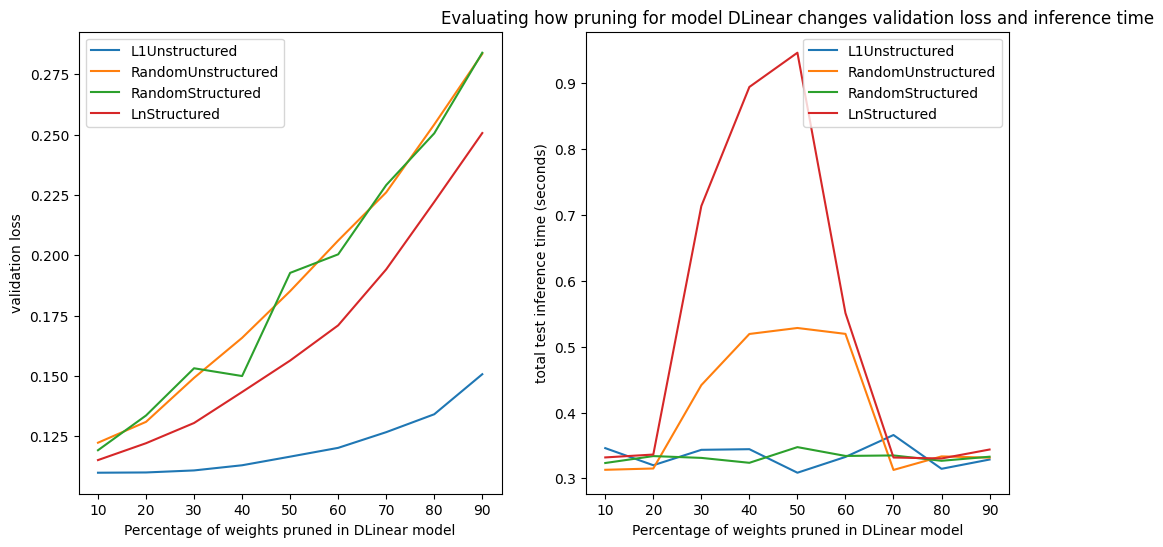

In [47]:
import matplotlib.pyplot as plt

if use_model == "SCI": 
  model = scinet
  model_config = test_config_SCI
else:
  model = dlinear
  model_config = test_config_DLinear

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

pruning_methods = [prune.L1Unstructured, prune.RandomUnstructured, prune.RandomStructured, prune.LnStructured]
for method in pruning_methods:
    losses = []
    times = []
    for percentage in range(10,100,10):   
        net = copy_model(model)
        loss, inference_time = global_prune(net, percentage, method, model_config)
        losses.append(loss)
        times.append(inference_time)
    axs[0].plot(range(10,100,10), losses, label=method.__name__)
    axs[1].plot(range(10,100,10), times, label=method.__name__)
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel(f"Percentage of weights pruned in {use_model} model")
axs[0].set_ylabel("validation loss")
axs[1].set_xlabel(f"Percentage of weights pruned in {use_model} model")
axs[1].set_ylabel("total test inference time (seconds)")
plt.title(f"Evaluating how pruning for model {use_model} changes validation loss and inference time")
plt.show()

In [51]:
# iterative pruning with finetuning
import torch.nn.utils.prune as prune

def iterative_pruning_with_finetuning(net, pruning_perc, pruning_method, num_iterations, num_epochs_per_iteration, config):
    """
    Perform iterative pruning on our models with fine-tuning.
    """
    # Get the pruning kwargs based on the pruning method and percentage
    pruning_kwargs = {"name": "weight", "amount": pruning_perc / 100}
    criterion = nn.MSELoss()

    for i in range(num_iterations):
        for module in net.modules():
            if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Conv1d):
                if pruning_method == prune.L1Unstructured:
                    prune.l1_unstructured(module, **pruning_kwargs)
                        
                elif pruning_method == prune.RandomUnstructured:
                    prune.random_unstructured(module, **pruning_kwargs)
                        
                elif pruning_method == prune.RandomStructured:
                    prune.random_structured(module, dim=1, **pruning_kwargs)

                elif pruning_method == prune.LnStructured:
                    prune.ln_structured(module, dim=1, n=2, **pruning_kwargs) # L2 norm
                    


        train_loader = DataLoader(
                                    train_data,
                                    batch_size=test_config_SCI.batch_size,
                                    shuffle=True,
                                    num_workers=2,
                                    drop_last=False)
        # Fine-tune the model
        model_optim = optim.Adam(net.parameters(), lr=config.lr)

        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
            if use_model == "SCI":
                if i > num_epochs_per_iteration:
                    break
                model_optim.zero_grad()
                pred, pred_scale, mid, mid_scale, true, true_scale = _process_one_batch_SCINet(
                          net, test_config_SCI.stacks, train_data, batch_x, batch_y)

                if test_config_SCI.stacks == 1:
                    loss = criterion(pred, true)
                elif test_config_SCI.stacks == 2:
                    loss = criterion(pred, true) + criterion(mid, true)
                loss.backward()
                model_optim.step()
            else:
                if i > num_epochs_per_iteration:
                    break
                model_optim.zero_grad()
                batch_x = batch_x.float().to(device)
                true = batch_y[:,-96:,0:].float().to(device)
                pred = net(batch_x)
                loss = criterion(pred, true)
                loss.backward()
                model_optim.step()

            for module in model.modules():
                if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Conv1d):
                    try:
                        prune.remove(module, pruning_kwargs["name"])
                    except:
                        continue
            
        # Update the pruning amount for the next iteration
        pruning_perc -= 2
        pruning_kwargs["amount"] = pruning_perc / 100

    valid_loader = DataLoader(
                    valid_data,
                    batch_size=config.batch_size,
                    shuffle=True,
                    num_workers=2,
                    drop_last=False)
    
    # compute inference time 
    inference_time = None
    test_loader = DataLoader(
            test_data,
            batch_size=config.batch_size,
            shuffle=False,
            num_workers=2,
            drop_last=True)

    net.eval()
    if use_model == "SCI": 
        start = time.time()
            
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
            if i > 20:
                break
            model_optim.zero_grad()
            pred, pred_scale, mid, mid_scale, true, true_scale = _process_one_batch_SCINet(
                    net, config.stacks, train_data, batch_x, batch_y)
        end = time.time()
        inference_time = end-start
    else:
        start = time.time()
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
            if i > 20:
                break
            model_optim.zero_grad()
            batch_x = batch_x.float().to(device)
            true = batch_y[:,-96:,0:].float().to(device)
            pred = net(batch_x)
        end = time.time()
        inference_time = end-start

    return valid(net, use_model, config, valid_data, valid_loader, criterion), end-start

	speed: 0.0155s/iter; elapsed time: 0.3414s
	speed: 0.0157s/iter; elapsed time: 0.3449s
	speed: 0.0157s/iter; elapsed time: 0.3460s
	speed: 0.0159s/iter; elapsed time: 0.3497s
	speed: 0.0166s/iter; elapsed time: 0.3651s
	speed: 0.0251s/iter; elapsed time: 0.5529s
	speed: 0.0161s/iter; elapsed time: 0.3548s
	speed: 0.0160s/iter; elapsed time: 0.3529s
	speed: 0.0161s/iter; elapsed time: 0.3550s
	speed: 0.0169s/iter; elapsed time: 0.3710s
	speed: 0.0167s/iter; elapsed time: 0.3678s
	speed: 0.0256s/iter; elapsed time: 0.5641s
	speed: 0.0157s/iter; elapsed time: 0.3461s
	speed: 0.0151s/iter; elapsed time: 0.3319s
	speed: 0.0155s/iter; elapsed time: 0.3409s
	speed: 0.0157s/iter; elapsed time: 0.3454s
	speed: 0.0153s/iter; elapsed time: 0.3364s
	speed: 0.0256s/iter; elapsed time: 0.5641s
	speed: 0.0165s/iter; elapsed time: 0.3628s
	speed: 0.0163s/iter; elapsed time: 0.3592s
	speed: 0.0161s/iter; elapsed time: 0.3537s
	speed: 0.0158s/iter; elapsed time: 0.3486s
	speed: 0.0163s/iter; elapsed ti

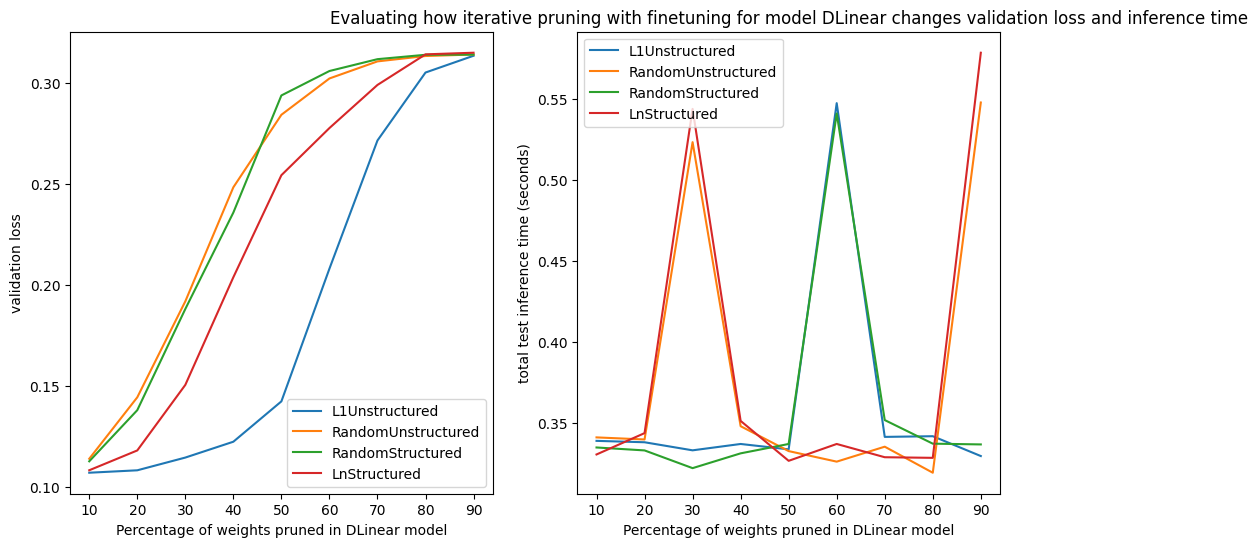

In [53]:
import matplotlib.pyplot as plt

if use_model == "SCI": 
  model = scinet
  model_config = test_config_SCI
else:
  model = dlinear
  model_config = test_config_DLinear

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

pruning_methods = [prune.L1Unstructured, prune.RandomUnstructured, prune.RandomStructured, prune.LnStructured]
for method in pruning_methods:
    losses = []
    times = []
    for percentage in range(10,100,10):   
        net = copy_model(model)
        iterative_pruned_loss, inference_time = iterative_pruning_with_finetuning(net, percentage, method, 5, 5, model_config)
        losses.append(iterative_pruned_loss)
        times.append(inference_time)
    axs[0].plot(range(10,100,10), losses, label=method.__name__)
    axs[1].plot(range(10,100,10), times, label=method.__name__)
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel(f"Percentage of weights pruned in {use_model} model")
axs[0].set_ylabel("validation loss")
axs[1].set_xlabel(f"Percentage of weights pruned in {use_model} model")
axs[1].set_ylabel("total test inference time (seconds)")
plt.title(f"Evaluating how iterative pruning with finetuning for model {use_model} changes validation loss and inference time")
plt.show()

In [84]:
def find_pruning_threshold(model, allowable_loss_increase_percentage, pruning_method, config):
    """
    Find the pruning threshold for each layer of a PyTorch model.
    """
    # Define the starting accuracy
    valid_loader = DataLoader(
                  valid_data,
                  batch_size=config.batch_size,
                  shuffle=True,
                  num_workers=2,
                  drop_last=False)
    criterion = nn.MSELoss()
    start_loss = valid(net, use_model, config, valid_data, valid_loader, criterion)


    pruning_thresholds = {}
    for percentage in range(10,10,100):
        # Iterate through each layer of the model
        pruning_kwargs = {"name": "weight", "amount": percentage / 100}

        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Conv1d):
                # Try ascending pruning percentages
                for name, module in net.named_modules():
                    if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Conv1d):                        
                        if pruning_method == prune.L1Unstructured:
                            prune.l1_unstructured(module, **pruning_kwargs)
                        
                        elif pruning_method == prune.RandomUnstructured:
                            prune.random_unstructured(module, **pruning_kwargs)
                        
                        elif pruning_method == prune.RandomStructured:
                            prune.random_structured(module, dim=1, **pruning_kwargs)

                        elif pruning_method == prune.LnStructured:
                            prune.ln_structured(module, dim=1, n=2, **pruning_kwargs) # L2 norm
                    

                        train_loader = DataLoader(
                                    train_data,
                                    batch_size=test_config_SCI.batch_size,
                                    shuffle=True,
                                    num_workers=2,
                                    drop_last=False)
                        # Fine-tune the model
                        model_optim = optim.Adam(net.parameters(), lr=config.lr)

                        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
                            if i > 5:
                              break
                            model_optim.zero_grad()
                            pred, pred_scale, mid, mid_scale, true, true_scale = _process_one_batch_SCINet(
                                net, test_config_SCI.stacks, train_data, batch_x, batch_y)

                            if test_config_SCI.stacks == 1:
                                loss = criterion(pred, true)
                            elif test_config_SCI.stacks == 2:
                                loss = criterion(pred, true) + criterion(mid, true)
                            loss.backward()
                            model_optim.step()
                            prune.remove(module, pruning_kwargs["name"])

                    # Test the loss
                    loss = valid(net, use_model, config, valid_data, valid_loader, criterion)

                    # If the new loss is above the threshold, stop pruning and print the result
                    if loss > start_loss * (1 + allowable_loss_increase_percentage/100):
                        print(f"Layer {name}: pruning threshold = {percentage - 10} %")
                        pruning_thresholds[name] = percentage-10
                        continue

    return pruning_thresholds

In [85]:
# experimenting with using optimal pruning thresholds for each layer, this didn't work well
net = copy_model(model)
thresholds = find_pruning_threshold(net, 20, prune.L1Unstructured, test_config_SCI)
print(thresholds)

	speed: 0.0403s/iter; elapsed time: 0.8865s
{}
